In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- DÉFINITION DES CHEMINS ---
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/Gestion-portefeuille/"

try:
    ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
except Exception:
    ROOT_DIR = Path.cwd()

INTERIM_DATA_PATH = ROOT_DIR / "data" / "interim"
PROCESSED_DATA_PATH = ROOT_DIR / "data" / "processed"
INPUT_FILENAME = "cac40_interim_features.csv"

# --- 1. FONCTION DE CHARGEMENT ET PRÉPARATION ---

def load_and_prepare_data():
    """Charge les données, sélectionne la dernière date et met à l'échelle."""
    filepath = INTERIM_DATA_PATH / INPUT_FILENAME
    if not filepath.exists():
        print(f"❌ Erreur : Fichier d'entrée non trouvé à {filepath}. Relancez l'étape 2.")
        return None, None

    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    latest_date = df['Date'].max()
    df_latest = df[df['Date'] == latest_date].copy().set_index('Ticker')

    FEATURES = ['Volatility', 'Sharpe_Ratio_20D', 'Performance_20D', 'Volume', 'Dividends']

    X = df_latest[FEATURES].copy()

    # Nettoyage et Imputation
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())

    # Normalisation
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=FEATURES, index=X.index)

    return X_scaled, df_latest

# --- Exécution de l'exploration ---
X_scaled, df_latest = load_and_prepare_data()

if X_scaled is None:
    print("Impossible de continuer sans données préparées.")
else:
    # ----------------------------------------------------
    # I. DIAGNOSTIC K (Méthode du Coude)
    # ----------------------------------------------------
    print("\n🔬 Diagnostic : Méthode du Coude pour K Optimal")

    sse = {}  # Sum of Squared Errors
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        sse[k] = kmeans.inertia_

    plt.figure(figsize=(10, 6))
    plt.plot(list(sse.keys()), list(sse.values()), marker='o')
    plt.title('Méthode du Coude pour K Optimal')
    plt.xlabel("Nombre de Clusters (K)")
    plt.ylabel("Somme des Carrés des Erreurs (SSE)")

    # Sauvegarde du plot (pas de show bloquant)
    elbow_path = PROCESSED_DATA_PATH / "diagnostic_elbow_method.png"
    plt.savefig(elbow_path, bbox_inches="tight")
    plt.close()

    # ----------------------------------------------------
    # II. VISUALISATION DES CLUSTERS (PCA)
    # ----------------------------------------------------

    # Réapplique K-Means avec K=4 (valeur choisie)
    K_CHOICE = 4
    kmeans_final = KMeans(n_clusters=K_CHOICE, random_state=42, n_init=10)
    clusters = kmeans_final.fit_predict(X_scaled)
    df_latest['Cluster'] = clusters

    print(f"\n📊 Visualisation de la séparation pour K = {K_CHOICE}")

    # Réduction de dimension (PCA pour 2D)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2'],
        index=df_latest.index
    )

    # Ajouter la colonne Cluster pour la visualisation
    pca_df['Cluster'] = clusters

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        pca_df['PC1'],
        pca_df['PC2'],
        c=pca_df['Cluster'],
        cmap='viridis',
        s=50,
        alpha=0.7
    )

    # Annoter les points avec le ticker
    for i, txt in enumerate(pca_df.index):
        plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=8, alpha=0.8)

    plt.title(f'Segmentation des Actifs du CAC 40 (K={K_CHOICE} - Visualisation PCA)')
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")

    # Légende pour la couleur
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)

    # Sauvegarde du plot (pas de show bloquant)
    pca_path = PROCESSED_DATA_PATH / "visualization_pca_clusters.png"
    plt.savefig(pca_path, bbox_inches="tight")
    plt.close()

    print(f"\n✅ Figures sauvegardées dans :\n - {elbow_path}\n - {pca_path}")



🔬 Diagnostic : Méthode du Coude pour K Optimal

📊 Visualisation de la séparation pour K = 4


/tmp/ipykernel_34805/1412866049.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=8, alpha=0.8)



✅ Figures sauvegardées dans :
 - /home/onyxia/work/Gestion-portefeuille/data/processed/diagnostic_elbow_method.png
 - /home/onyxia/work/Gestion-portefeuille/data/processed/visualization_pca_clusters.png


K-Means + DBSCAN


🔍 DBSCAN : 2 outliers détectés


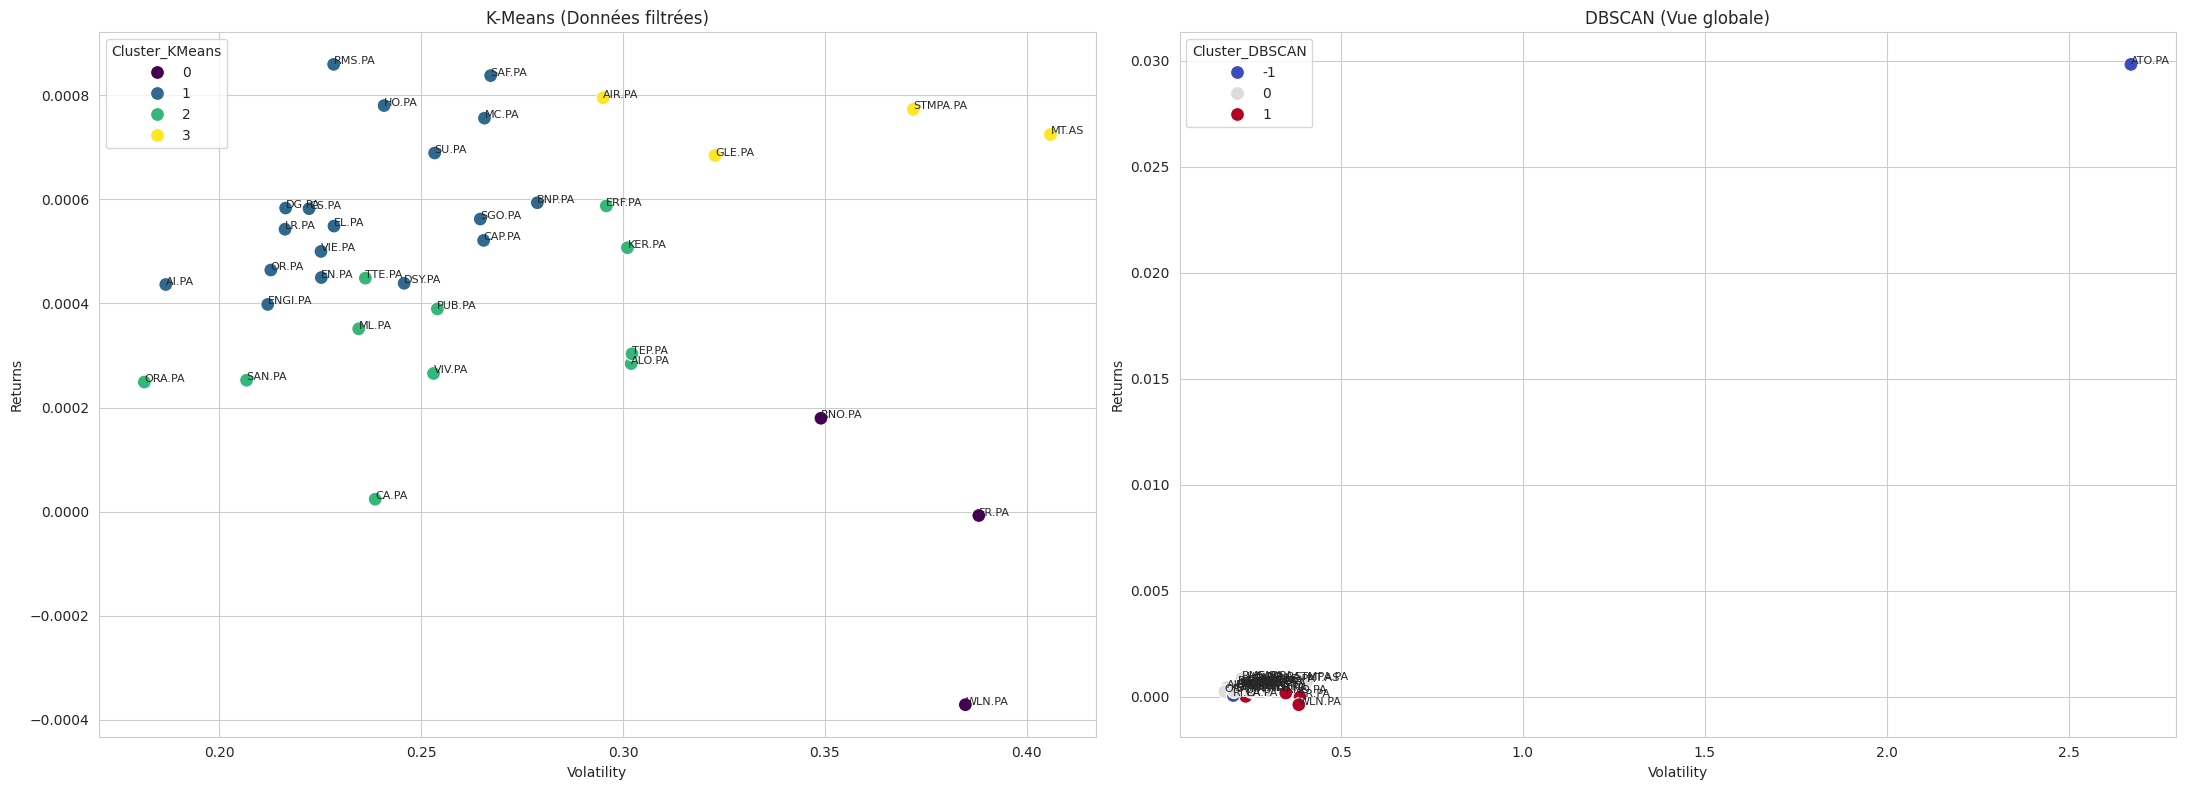

✅ Répartition finale : {-1: 2, 0: 3, 1: 18, 2: 11, 3: 4}


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from pathlib import Path

# 1. Chargement et Agrégation
df = pd.read_csv("/home/onyxia/work/Gestion-portefeuille/data/interim/cac40_interim_features.csv")
features = ['Returns', 'Volatility', 'Sharpe_Ratio_20D']
cluster_data = df.groupby('Ticker')[features].mean().dropna()

# 2. DBSCAN : Détection des anomalies
scaler_all = StandardScaler()
scaled_all = scaler_all.fit_transform(cluster_data[features])
dbscan = DBSCAN(eps=0.5, min_samples=3)
cluster_data['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_all)

print(f"🔍 DBSCAN : {(cluster_data['Cluster_DBSCAN'] == -1).sum()} outliers détectés")

# 3. K-Means : Uniquement sur les données filtrées
mask_clean = cluster_data['Cluster_DBSCAN'] != -1
cluster_data_clean = cluster_data[mask_clean].copy()

scaler_clean = StandardScaler()
scaled_clean = scaler_clean.fit_transform(cluster_data_clean[features])
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_data_clean['Cluster_KMeans'] = kmeans.fit_predict(scaled_clean)

# 4. Reconstruction du Mapping Final
cluster_data['Cluster'] = -1  # Outliers par défaut
cluster_data.loc[mask_clean, 'Cluster'] = cluster_data_clean['Cluster_KMeans'].values

# 5. Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

# Graphique K-Means (données nettoyées)
sns.scatterplot(data=cluster_data_clean, x='Volatility', y='Returns', 
                hue='Cluster_KMeans', palette='viridis', s=100, ax=ax1)
for ticker in cluster_data_clean.index:
    ax1.text(cluster_data_clean.loc[ticker, 'Volatility'], 
             cluster_data_clean.loc[ticker, 'Returns'], 
             ticker, fontsize=8)
ax1.set_title('K-Means (Données filtrées)')

# Graphique DBSCAN (toutes les données)
sns.scatterplot(data=cluster_data, x='Volatility', y='Returns', 
                hue='Cluster_DBSCAN', palette='coolwarm', s=100, ax=ax2)
for ticker in cluster_data.index:
    ax2.text(cluster_data.loc[ticker, 'Volatility'], 
             cluster_data.loc[ticker, 'Returns'], 
             ticker, fontsize=8)
ax2.set_title('DBSCAN (Vue globale)')

plt.tight_layout()
plt.show()

# 6. Sauvegarde
processed_path = Path("/home/onyxia/work/Gestion-portefeuille/data/processed")
processed_path.mkdir(parents=True, exist_ok=True)
cluster_data[['Cluster']].to_csv(processed_path / "clusters_mapping.csv")

print(f"✅ Répartition finale : {cluster_data['Cluster'].value_counts().sort_index().to_dict()}")

CAH

/tmp/ipykernel_34805/721126094.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


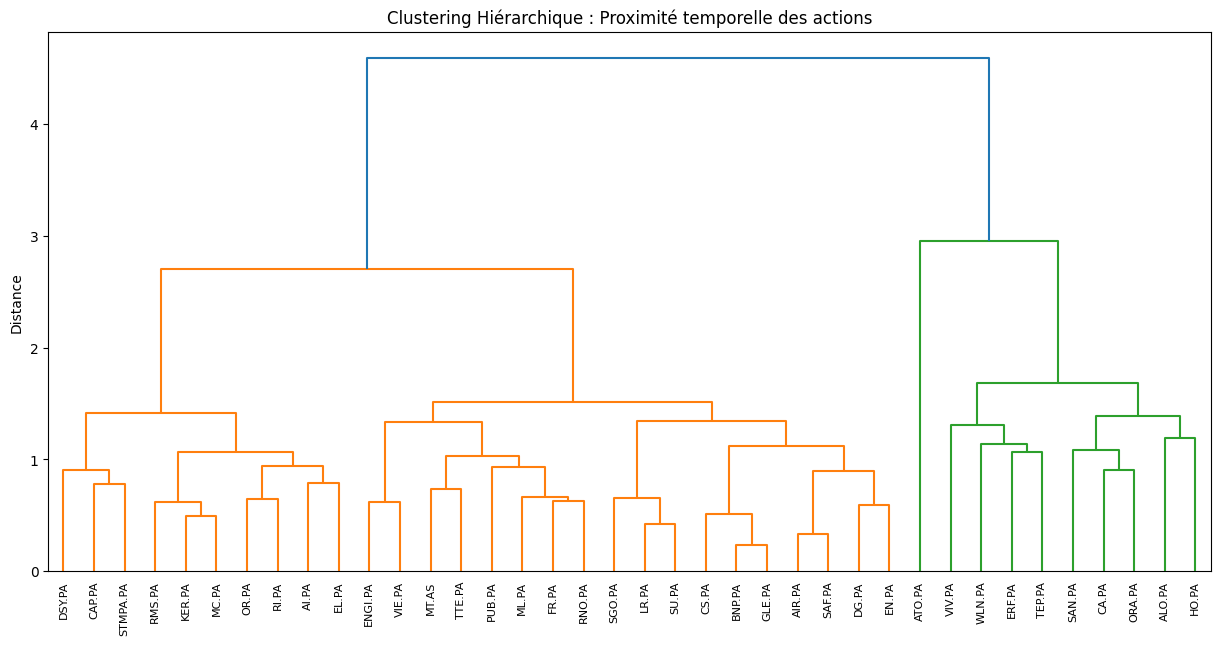

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. On utilise la matrice de corrélation que tu as déjà calculée
# On transforme la corrélation en 'distance' (plus ils sont corrélés, plus la distance est petite)
distance_matrix = 1 - corr_matrix

# 2. Calcul du lien hiérarchique
Z = linkage(distance_matrix, method='ward')

# 3. Affichage du Dendrogramme
plt.figure(figsize=(15, 7))
dendrogram(Z, labels=corr_matrix.index, leaf_rotation=90)
plt.title("Clustering Hiérarchique : Proximité temporelle des actions")
plt.ylabel("Distance")
plt.show()


Matrice de corrélation

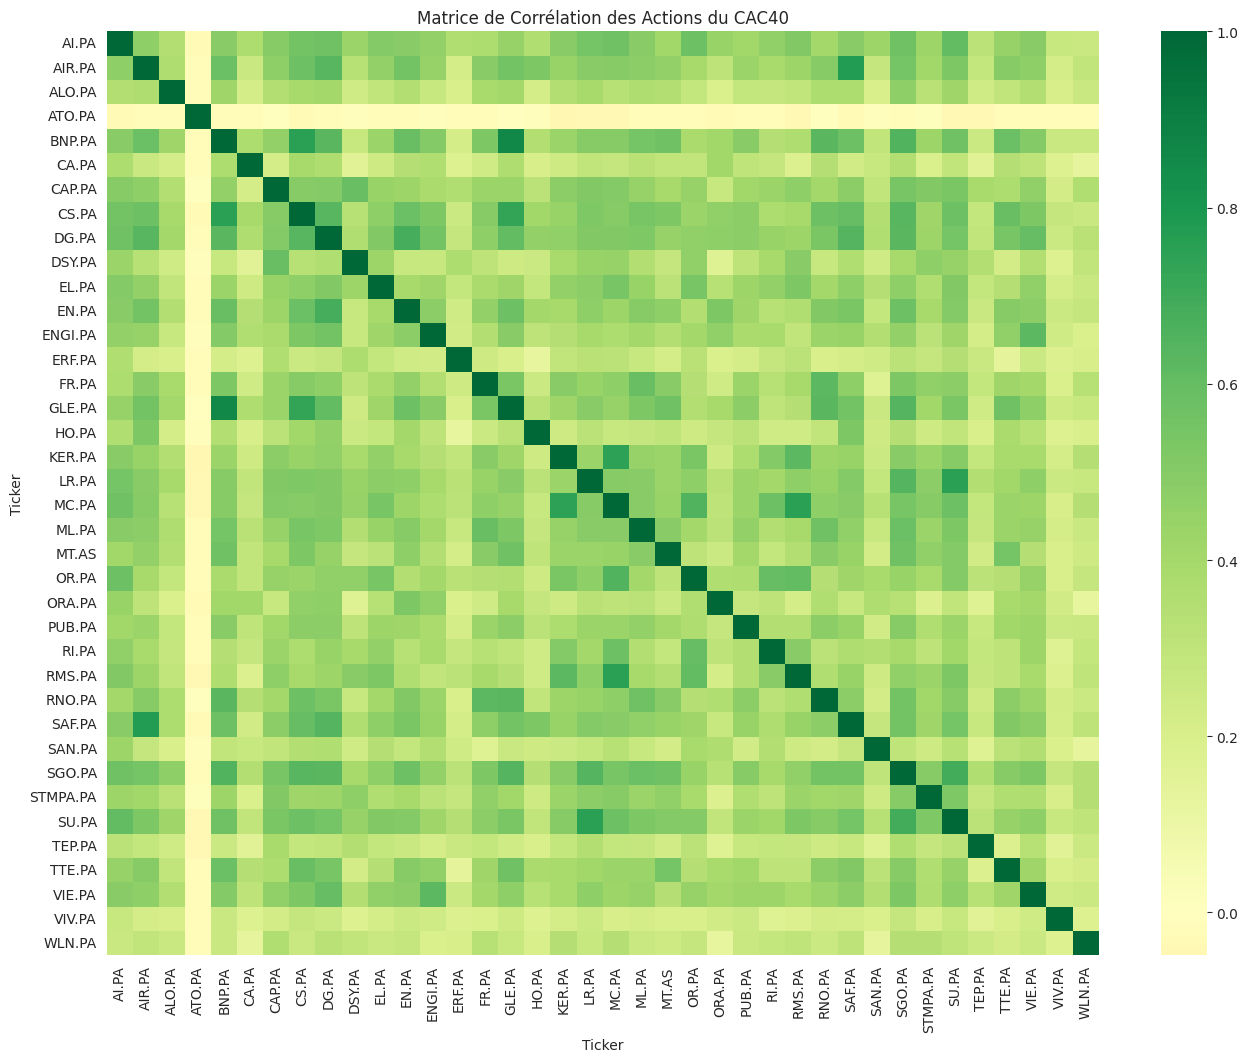

In [11]:
import seaborn as sns

# 1. On repart des rendements quotidiens (il faut pivoter les données)
# On utilise le fichier 'interim' qui contient les rendements par date
df_returns = pd.read_csv("/home/onyxia/work/Gestion-portefeuille/data/interim/cac40_interim_features.csv")
df_pivot = df_returns.pivot(index='Date', columns='Ticker', values='Returns')

# 2. Calcul de la matrice de corrélation de Pearson
corr_matrix = df_pivot.corr()

# 3. Affichage de la Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='RdYlGn', center=0)
plt.title('Matrice de Corrélation des Actions du CAC40')
plt.show()

MaxDrawdown

In [34]:
import pandas as pd
import numpy as np

# 1. Chargement des données
df_hist = pd.read_csv("/home/onyxia/work/Gestion-portefeuille/data/interim/cac40_interim_features.csv")

# 2. Fonction MDD robuste
def compute_mdd(series):
    """Calcule le Maximum Drawdown en gérant les cas limites"""
    series = series.dropna()
    
    if len(series) < 2:
        return np.nan
    if (series <= 0).any():
        return np.nan
    
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    return drawdown.min()

# 3. Calcul du MDD par ticker
mdd_per_ticker = df_hist.groupby('Ticker')['Close'].apply(compute_mdd)
print(f"✅ MDD calculé pour {mdd_per_ticker.notna().sum()}/{len(mdd_per_ticker)} tickers")

# 4. Ajout au DataFrame avec alignement sécurisé
# IMPORTANT : cluster_data doit déjà exister (créé lors du clustering)
if 'cluster_data' not in locals():
    raise NameError("❌ Vous devez d'abord exécuter le script de clustering !")

cluster_data['Max_Drawdown'] = cluster_data.index.map(mdd_per_ticker)

# 5. Vérifications
n_missing = cluster_data['Max_Drawdown'].isna().sum()
if n_missing > 0:
    print(f"⚠️ {n_missing} tickers sans MDD :")
    print(cluster_data[cluster_data['Max_Drawdown'].isna()].index.tolist())

# 6. Affichage enrichi
cols_to_show = [c for c in ['Cluster', 'Returns', 'Volatility', 'Max_Drawdown'] 
                if c in cluster_data.columns]

print("\n📊 Profil Risque/Rendement complet :")
display_df = cluster_data[cols_to_show].sort_values('Max_Drawdown')
print(display_df.to_string())  # Affiche tout, pas juste head()

# 7. Analyse par cluster
if 'Cluster' in cluster_data.columns:
    print("\n📈 Moyennes par Cluster :")
    cluster_stats = cluster_data.groupby('Cluster')[['Returns', 'Volatility', 'Max_Drawdown']].agg(['mean', 'std'])
    print(cluster_stats)
    
    # Identifier le cluster le plus résilient
    cluster_mdd = cluster_data.groupby('Cluster')['Max_Drawdown'].mean()
    best_cluster = cluster_mdd.idxmax()  # MDD le plus proche de 0 (le moins négatif)
    print(f"\n🏆 Cluster le plus résilient : {best_cluster} (MDD moyen = {cluster_mdd[best_cluster]:.2%})")

✅ MDD calculé pour 38/38 tickers

📊 Profil Risque/Rendement complet :
          Cluster   Returns  Volatility  Max_Drawdown
Ticker                                               
ATO.PA         -1  0.029835    2.671451     -0.998421
WLN.PA          0 -0.000371    0.384794     -0.984524
FR.PA           0 -0.000007    0.388124     -0.878763
VIV.PA          2  0.000266    0.253041     -0.854166
TEP.PA          2  0.000303    0.302200     -0.840796
RNO.PA          0  0.000179    0.349020     -0.835496
MT.AS           3  0.000725    0.405871     -0.786232
KER.PA          2  0.000507    0.301071     -0.781749
ALO.PA          2  0.000284    0.301997     -0.774664
GLE.PA          3  0.000684    0.322784     -0.747772
PUB.PA          2  0.000389    0.253985     -0.687191
STMPA.PA        3  0.000773    0.371884     -0.663372
AIR.PA          3  0.000795    0.295048     -0.647014
SAF.PA          1  0.000838    0.267184     -0.646323
ERF.PA          2  0.000587    0.295848     -0.639349
SGO.PA      